In [42]:
# Import packages
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import os
from set_paths import data_path
import seaborn as sns
from scipy import stats
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr

In [43]:
### Load data ###

## Load data input to UMAP ##
struct_data = sio.loadmat(os.path.join(data_path, "umap_input_data.mat"))['mat']

# Initialize an empty list to store the field data
field_data_list = []
# Iterate over each field in the struct
for field_name in struct_data.dtype.names:
    # Extract the 2-dimensional array from each field
    field_data = struct_data[field_name][0]
    # Flatten the nested arrays
    field_data_flat = np.concatenate(field_data).ravel()
    # Append the flattened field data to the list
    field_data_list.append(field_data_flat)
# Create the DataFrame from the list of flattened field data
input_data = pd.DataFrame(field_data_list).transpose()
# Column names
colnames = ['age','global_efficiency','path_length', 'small_worldness','strength',
            'modularity', 'core/periphery', 'score', 'local_efficiency', 
            'clustering', 'betweenness', 'subgraph_centrality']
input_data.columns = colnames
ages = input_data['age']
# Group by age
grouped_input_data = input_data.groupby('age').mean().reset_index()

## Load LASSO data ##
mat_file = sio.loadmat(os.path.join(data_path, "lasso_coefs.mat"))
lasso_data = np.array(mat_file['all_coefs'])

In [44]:
### Define variables ###

# Metrics
measures = ['Global Efficiency', 'Path Length', 'Small-Worldness','Strength',
                  'Modularity', 'Core/Periphery', 'S-Core', 'Local Efficiency', 
                  'Clustering Coefficient', 'Betweenness Centrality', 'Subgraph Centrality']
# Epochs
epoch_ranges = [
    (0,8),
    (8,32),
    (32,62),
    (62,85),
    (85,90)]

# Colors for epochs
line_colors = ['#FF5AAF','#008DF9','#FFC33B','#009F81','#A40122']

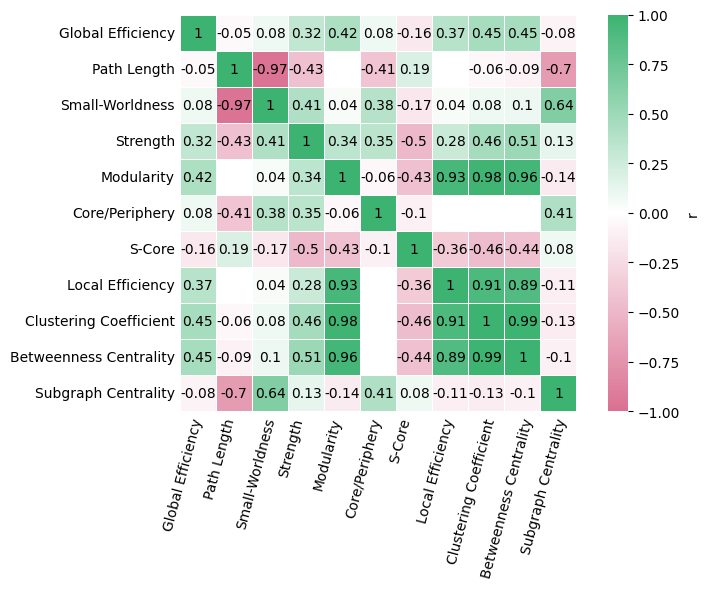

In [45]:
### Correlations ###

# Initialize matrices for r-values and p-values
num_vars = len(measures)
r_values = np.zeros((num_vars, num_vars))
p_values = np.zeros((num_vars, num_vars))
# Compute correlations for each epoch
for i in range(num_vars):
    for j in range(num_vars):
        var1 = measures[i]
        var2 = measures[j]
        r, p = pearsonr(input_data.iloc[:, i], input_data.iloc[:, j])
        r_values[i, j] = np.round(r,2)
        p_values[i, j] = p
        
# Mask for non-significant correlations (p >= 0.05)
mask = p_values >= 0.05
masked_r_values = np.ma.masked_where(mask, r_values)
colors = [(0.8549, 0.4392, 0.5725), (1, 1, 1), (0.2353, 0.7020, 0.4431)]  # Red, white, green 
cmap1 = LinearSegmentedColormap.from_list("CustomMap", colors, N=256)     # Create colormap

### Extended Data Figure 3a ###
plt.figure(figsize=(8, 6))
sns.heatmap(
    r_values, 
    annot=True, 
    cmap=cmap1, 
    vmin=-1, 
    vmax=1, 
    square=True, 
    cbar_kws={'label': 'r'},
    linewidths=0.5,
    mask=mask,    # White-out not significant values
    annot_kws={"color": "black", "fontname": "Arial"},
)

# Shift x-axis tick labels slightly to the left
ax = plt.gca()
# Configure x-axis tick labels
xticks = np.arange(len(measures)) + 0.5  # Original tick positions
ax.set_xticks(xticks - 0.4)  # Shift left
ax.set_xticklabels(measures, rotation=75, fontname='Arial')

# Configure y-axis tick labels
ax.set_yticks(np.arange(len(measures)) + 0.5)
ax.set_yticklabels(measures, rotation=0, fontname='Arial')

# Remove tick marks but keep the labels visible
ax.tick_params(axis='x', which='both', length=0)  # No x-axis tick marks
ax.tick_params(axis='y', which='both', length=0)  # No y-axis tick marks

# Show plot
plt.tight_layout()
plt.show()

In [46]:
# Save r and pvalues

# Initialize
corrs = np.zeros([len(epoch_ranges), len(measures)], dtype="object")
pvals = np.zeros([len(epoch_ranges), len(measures)], dtype="object")
# Loop through epochs
for epoch_index, (start, end) in enumerate(epoch_ranges):
    # Pull data
    epoch_data = input_data[(input_data['age'] >= start) & (input_data['age'] <= end)]
    sample_size = epoch_data.shape[0]
    x = epoch_data.iloc[:, 1:end] # Pull graph theory measures
    y = epoch_data.iloc[:, 0]     # Pull age
    # Loop through meausres
    for c in range(x.shape[1]):
        measure = x.iloc[:,c]
        # Pearson correlation
        test = stats.pearsonr(measure, y)
        corrs[epoch_index,c] = test[0]
        pvals[epoch_index,c] = test[1]

/home/am11/.conda/envs/alexa_env/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning:

FixedFormatter should only be used together with FixedLocator



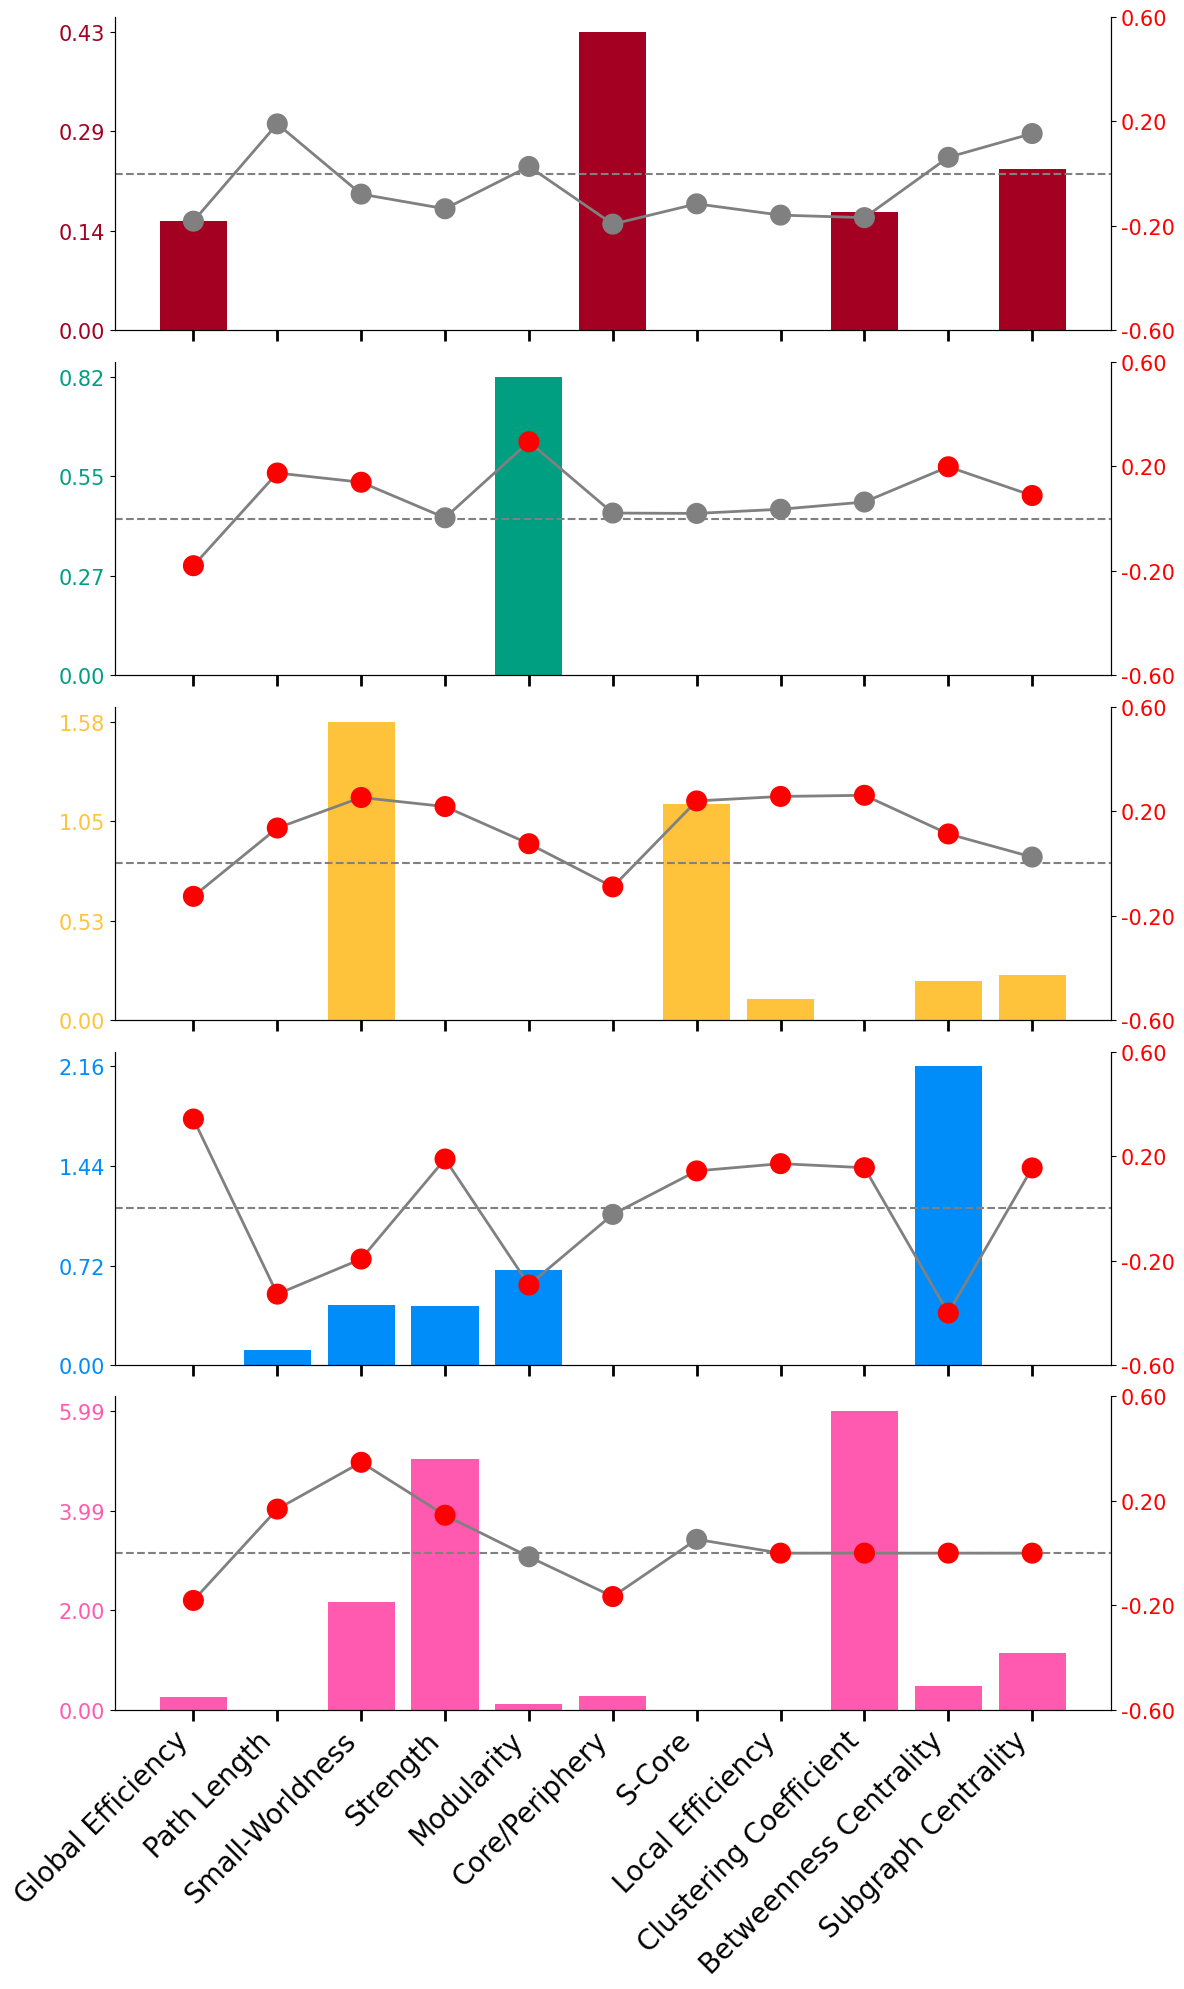

In [47]:
### Figure 4b-f ###

# Create figure and subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20))
# Loop through each epoch
for e in range(5):
    ax1 = axes[4 - e]  # Reverse the order of the plots so youngest is last
    
    # Pull data for this epoch
    epoch_lasso = lasso_data[e,]
    epoch_corr = corrs[e,]
    epoch_pvals = np.array(pvals[e,])

    # Bar plot for beta values
    color = line_colors[e]
    ax1.bar(measures, epoch_lasso, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=15)

    # Set 4 ticks for ax1 (beta values)
    y1_ticks = np.linspace(min(epoch_lasso), max(epoch_lasso), 4)  # 4 evenly spaced ticks
    ax1.set_yticks(y1_ticks)
    ax1.set_yticklabels([f'{tick:.2f}' for tick in y1_ticks],)     # Format labels as desired

    # Plot graph theory measure labels only on the last plot
    if e == 0:
        ax1.set_xticklabels(measures, rotation=45, ha='right', family='Arial', fontsize=20)
    else:
        ax1.set_xticklabels([])
    ax1.spines['top'].set_visible(False)

    # Create a second y-axis for r values
    ax2 = ax1.twinx()
    color = 'grey'
    ax2.axhline(0, color='grey', linestyle='--')
    ax2.spines['top'].set_visible(False)
    ax2.set_ylim(-0.6, 0.6)

    # Set 4 ticks for ax2 (r values)
    y2_ticks = np.linspace(-0.6, 0.6, 4) 
    ax2.set_yticks(y2_ticks)
    ax2.set_yticklabels([f'{tick:.2f}' for tick in y2_ticks], color='red')

    # Color scatter points based on p-values
    colors = ['red' if p < 0.05 else 'grey' for p in epoch_pvals]
    ax2.scatter(measures, epoch_corr, color=colors, marker='o', s=200, zorder=5)
    ax2.plot(measures, epoch_corr, color=color, linestyle='-', linewidth=2, markersize=6)
    ax2.tick_params(axis='y', labelcolor='red', labelsize=15)
    
    # Increase the size of x-axis tick labels
    ax1.tick_params(axis='x', which='both', bottom=True, top=False, direction='out', width=2, length=8)  
# Adjust layout of subplots 
fig.tight_layout()
plt.subplots_adjust(hspace=0.1) 
# Show plot
plt.show()


In [48]:
### Extended Data Figure 4a ###

# Create function for spider plots
def create_epoch_plot(epoch1, epoch2, index1, index2):
    fig = go.Figure()

    # Add traces for the two epochs
    fig.add_trace(
        go.Scatterpolar(
            r=corrs[index1, :],
            name='',
            fillcolor=fill_colors[index1],
            line=dict(color=line_colors[index1], width=8),
            theta=measures,
            fill='toself',
            showlegend=False
        )
    )
    fig.add_trace(
        go.Scatterpolar(
            r=corrs[index2, :],
            name='',
            fillcolor=fill_colors[index2],
            line=dict(color=line_colors[index2], width=8),
            theta=measures,
            fill='toself',
            showlegend=False
        )
    )

    # Update layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[-0.7, 0.7],
                tickvals=[0],
                tickfont=dict(color='black', size=22)
            ),
            angularaxis=dict(
                tickfont=dict(color='black', size=22)
            )
        ),
        title=dict(text=f"{epoch1} and {epoch2}", font=dict(size=24, color='black')),
        showlegend=False
    )

    # Show the figure
    fig.show()

# Create and show plots
create_epoch_plot('Epoch: 0-8 Years', 'Epoch: 8-32 Years', 0, 1)
create_epoch_plot('Epoch: 8-32 Years', 'Epoch: 32-62 Years', 1, 2)
create_epoch_plot('Epoch: 32-62 Years', 'Epoch: 62-85 Years', 2, 3)
create_epoch_plot('Epoch: 62-85 Years', 'Epoch: 85-90 Years', 3, 4)